# 트레이딩 전략과 구현
## 01 현대 포트폴리오 이론
### 01.1 수익률의 표준편차
> 수익률의 표준편차 (Standard deviation of returns)
> - 자산 가격이 평균값에서 벗어나는 정도, 즉 리스크를 측정하는 방법
> - 주식 시장에서의 리스크는 흔히 주가의 변동성을 의미한다.
> - 정규분포 그래프에서 예상 수익률은 평균값인 $\mu$(뮤)로 나타내고, 리스크는 표준편차인 $\sigma$(시그마)로 나타낸다.

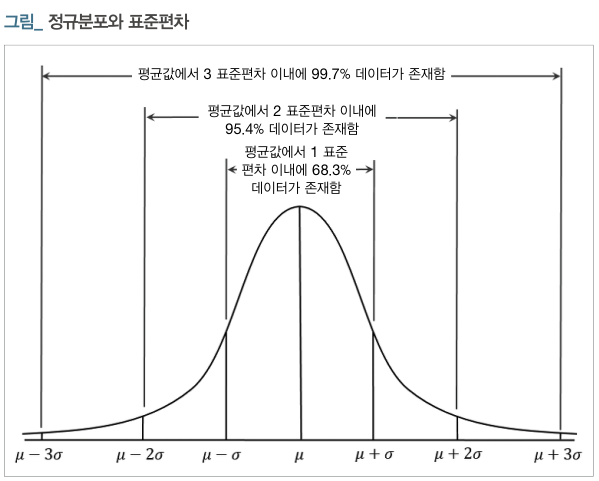

In [1]:
from IPython.display import Image
Image('./image/01_normal_distribution.png' , width=700)

> 예를 들어, 예상 수익률($\mu$)이 7%, 수익률의 표준편차($\sigma$)가 5%인 주식이라면 그 주식은 2%에서 12% 사이의 수익을 낼 확률이 68.7%가 된다.
>
> 2%($\mu-\sigma$)는 7%($\mu$)의 왼쪽으로 표준편차 1이고, 12%($\mu+\sigma$)는 7%($\mu$)의 오른쪽으로 표준편차 1이다.

### 01.2 효율적 투자선
> 효율적 투자선(Efficient Frontier)
> - 현대 포트폴리오 이론의 핵심 개념. 투자자가 인내할 수 있는 리스크 수준에서 최상의 기대수익률을 제공하는 포트폴리오 집합을 의미한다.
> - 효율적 투자선 위에 위치한 포트폴리오는 주어진 리스크에서 최대 수익을 낸다.

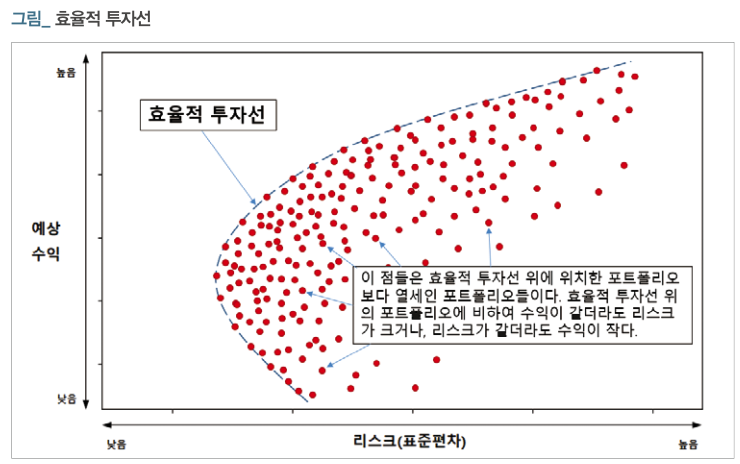

In [4]:
Image('./image/02_efficient_frontier.png' , width=700)

#### 시총 상위 4 종목으로 효율적 투자선 구하기
- MarketDB 클래스의 일별 시세 조회 API 사용

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceAnalyzer.Analyzer

mk = FinanceAnalyzer.Analyzer.MarketDB()
stocks = ['삼성전자', 'SK하이닉스', 'NAVER', '삼성바이오로직스']
df = pd.DataFrame()
for s in stocks :
    df[s] = mk.get_daily_price(s, '2019-01-01', '2021-10-07')['close']

In [56]:
df

,삼성전자,SK하이닉스,NAVER,삼성바이오로직스
date,,,,
2019-01-02,38750,60600,118000,374000
2019-01-03,37600,57700,122000,376500
2019-01-04,37450,58300,125500,381000
2019-01-07,38750,58700,131500,388000
2019-01-08,38100,59200,130000,386000
...,...,...,...,...
2021-09-30,74100,103000,388000,874000
2021-10-01,73200,100000,382000,875000
2021-10-05,72200,97900,370500,812000


In [57]:
# 수익률을 비교하려면 종가 대신 일간 변동률 비교
daily_ret = df.pct_change()
# 일간 변동률의 평균값에 252를 곱해 연간 수익률 구하기(252는 미국 1년 개장일)
annual_ret = daily_ret.mean() * 252
# 일간 리스크는 cov() 함수를 사용해 일간 변동률의 공분산으로 구함
daily_cov = daily_ret.cov()
# 연간 공분산은 일간 공분산에 252를 곱해 계산
annual_cov = daily_cov * 252

port_ret = []
port_risk = []
port_weights = []

**몬테카를로 시뮬레이션**
- 시총 상위 4종목으로 구성된 포트포리오 20,000개 생성
- numpy random()함수를 사용해 각 포트폴리오에 포함된 4종목의 비중이 모두 다르도록 한다.
- 이처럼 매우 많은 난수를 이용해 함수의 값을 확률적으로 계산하는 것을 몬테카를로 시뮬레이션이라 한다.

In [58]:
for _ in range(20000): # for in 구문에서 반복횟수를 사용할 일이 없으면 관습적으로 _ 변수 할당
    weights = np.random.random(len(stocks)) # 4개의 랜덤 숫자로 구성된 배열 생성
    weights /= np.sum(weights) # 위에서 구한 4개의 랜덤 숫자를 랜덤 숫자의 총합으로 나눠 4종목 비중의 합이 1이 되도록 한다.

    # 랜덤 생성한 종목별 비중 배열과 종목별 연간 수익률을 곱해 포트폴리오 전체 수익률(returns)을 구한다
    returns = np.dot(weights, annual_ret) 
    # 종목별 연간 공분산과 종목별 비중 배열을 곱한 뒤, 이를 다시 종목별 비중의 전치로 곱한다.
    # 이렇게 구한 결괏값의 제곱근을 구하면 해당 포트폴리오 전체 리스크를 구할 수 있다.
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))
    
    # 포트폴리오 20,000개 수익률, 리스크, 종목별 비중을 각각 리스트에 추가한다.
    port_ret.append(returns) 
    port_risk.append(risk)
    port_weights.append(weights)
    
portfolio = {'Returns': port_ret, 'Risk': port_risk}
for i, s in enumerate(stocks): # i값은 0, 1, 2, 3 ..., s값은 삼성전자, ...
    portfolio[s] = [weight[i] for weight in port_weights] # portfolio 딕셔너리에 종목별로 비중값 추가
df = pd.DataFrame(portfolio)
df = df[['Returns', 'Risk'] + [s for s in stocks]] # 종목의 보유 비율에 따라 포트폴리오가 각기 다른 리스크와 예상 수익률을 갖는다.
df

,Returns,Risk,삼성전자,SK하이닉스,NAVER,삼성바이오로직스
0,0.330816,0.270787,0.326950,0.089601,0.064488,0.518961
1,0.351257,0.270061,0.029182,0.336841,0.210380,0.423598
2,0.334186,0.253777,0.261946,0.207063,0.144995,0.385995
3,0.372564,0.243645,0.281748,0.120952,0.352347,0.244953
4,0.363412,0.243573,0.275071,0.144420,0.304080,0.276429
...,...,...,...,...,...,...
19995,0.304489,0.258323,0.299696,0.335634,0.078156,0.286514
19996,0.306056,0.272734,0.145173,0.442815,0.071682,0.340329
19997,0.384388,0.261261,0.076571,0.283001,0.429638,0.210790
19998,0.281352,0.286787,0.317228,0.522351,0.094211,0.066211


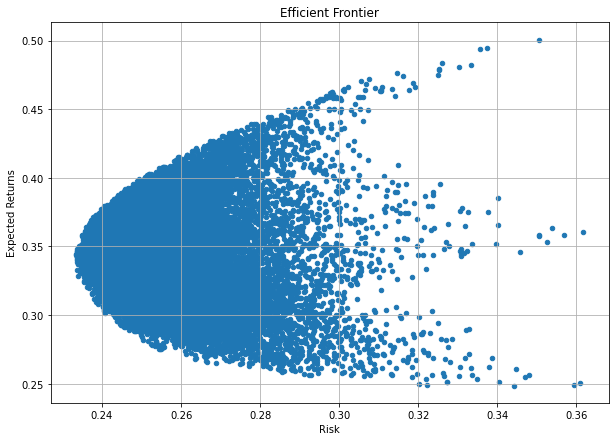

In [59]:
# 산점도로 출력 (몬테카를로 시뮬레이션으로 생성한 효율적 투자선)
df.plot.scatter(x='Risk', y='Returns', figsize=(10,7), grid=True)
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

## 02. 샤프 지수와 포트폴리오 최적화